In [3]:
# Imports and initialization
%pylab inline

import sys, os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
import inspect,pickle,imp,re,json,copy
from scipy.optimize import curve_fit
import pandas as pd

from ipywidgets import Checkbox
from IPython.display import display

import thulium_python_lib.usefull_functions as usfuncs
import thulium_python_lib.image_processing_new as impr

import ipyparallel as ipp
ipp.CompositeError.tb_limit = 1
rc1 = ipp.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
dview['par_dir'] = par_dir
%px import sys, os, imp
%px if par_dir not in sys.path: sys.path.append(par_dir)
%px import thulium_python_lib.image_processing_new as impr
# %px from ipyparallel import bind_kernel; bind_kernel()

import pymongo, datetime
from pymongo import MongoClient
from bson.objectid import ObjectId

#start mongoDB client (mongod server should be launched)
client = MongoClient('mongodb://192.168.1.15:27017/')
meas_database = client.measData.meas_data

Populating the interactive namespace from numpy and matplotlib
Done importing, module image_processing now


In [4]:
# to reload library on remote and local engine
# %px imp.reload(impr)
# imp.reload(impr)
# imp.reload(usfuncs)

### And now:
#### Choose working directory and measurement folder

In [7]:
# smth like 'D:\!Data\2015_08_20' for lab and like '/Users/artemgolovizin/Downloads/2015_08_20' for mac
os.chdir(r'\\BIGONE\!Data\2016_05_06 T and tau green next next_double_structure')
# os.chdir(r'/Users/artemgolovizin/Downloads/2015_08_20/')
current_directory = os.path.split(os.getcwd())[-1]
# Create folder 'Figures' for saving individual plot
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print('Folder Figures has been created')
working_directory = ''
folder = ''

In [151]:
# specify working folder
folder = '54 as 52 a=2dBm/'
working_directory = os.path.join(os.getcwd(),folder)

dirs = [x for x in os.listdir() if re.match('\d',x)]
meas_type, conf_params, x_lbl, y_lbl, xaxis_calib = impr.get_x_calibration(folder, dirs)

Checkboxes for specify do normalization or not

In [152]:
#checkboxes for specify workflow
do_individual_image_normalization = Checkbox(
     description='Do individual image normalization?',
     value=False,
)
display(do_individual_image_normalization)

do_average_image_normalization = Checkbox(
     description='Do average image normalization?',
     value=False,
)
display(do_average_image_normalization)

do_two_gaussian_fit = Checkbox(
     description='do_two_gaussian_fit?',
     value=True,
)
display(do_two_gaussian_fit)

### Load data, rearange, average and calibrate
 Constract loader and averager. For available parameters see help('instance')

In [153]:
# create loader
loader  = impr.Load_Image(dview, do_fit1D_x=True, do_fit1D_y=True)
# downloading images
all_data = loader(working_directory,lview)

# rearranging to dictionary
dataD = impr.rearrange_data(all_data)

# normalization
if do_individual_image_normalization.value:
    dataD = normalise_individual_image(dataD, 1, 2, 'fit1D_x', index=0)

  90/90 tasks finished after    0 s
done

Total number of images:  90
Rearranging to dictionary is complited


In [154]:
# create averager
averager = impr.Avr_Image(dview,do_sifting=True,conf_int=0.1)
# averaging data and fitting
avr_dataD = averager(dataD,lview)
# normalization
if do_average_image_normalization.value:
    avr_dataD = normalize_average_image(avr_dataD,1,2,'fit1D_x',0)
if do_two_gaussian_fit.value:
#     avr_dataD = impr.two_gaussian_fit(avr_dataD,p00=[15,10,76,20,40,0],fix_N_cool=True)
    avr_dataD = impr.two_gaussian_fit2(avr_dataD)

# construct new data dictionary without image and calibration atoms number, size and x-axis
navrD = impr.mod_avrData(avr_dataD, xaxis_calib, impr.N_atoms(gain=400, exposure=200, power=6.3, width=1.85, delta = 6), impr.real_size)

avr_table = impr.get_pandas_table2(navrD)
# for plotting sifted image
#imshow(imread('1 от частоты амплитудной модуляции аома верди (5) 3.9W/26ms/2_1.png'))
#colorbar()

   9/9 tasks finished after    0 s
done
0 images are sifted in folder=0.000000,shot_typeN=1
0 images are sifted in folder=1.000000,shot_typeN=1
0 images are sifted in folder=3.000000,shot_typeN=1
0 images are sifted in folder=4.000000,shot_typeN=1
0 images are sifted in folder=5.000000,shot_typeN=1
0 images are sifted in folder=7.000000,shot_typeN=1
0 images are sifted in folder=8.000000,shot_typeN=1
0 images are sifted in folder=9.000000,shot_typeN=1
0 images are sifted in folder=10.000000,shot_typeN=1



### Construct data based on measurement type and plot

D:\!Data\thulium_python_lib\image_processing_new.py:625: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if data[k]!=None and type(data[k])!=str:


Number of atoms 6788168 +- 357476


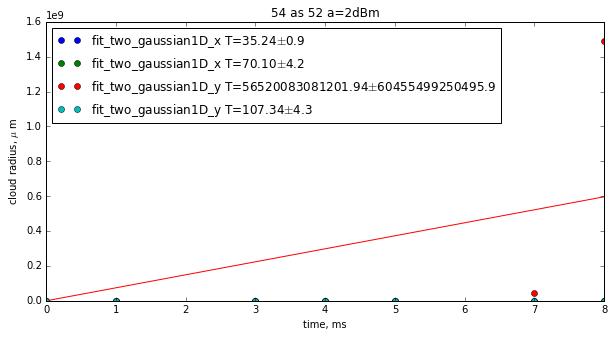

In [155]:
# shot_typeN - for now only 1, if there will be calibration - 1 or more
shot_typeN = 1

# description to add to all_data.txt file
description = dict()
description['meas_type'] = meas_type
description['x_label'] = x_lbl
description['y_label'] = y_lbl
fit_func = None
fits_list = []
fig1, ax1 = subplots(figsize=(10,5))
if meas_type == 'T':
    # construct data with cloud expansion on both coordinates
    # first set of data  - Temperature X
    d=[]
    fit_func = usfuncs.cloud_expansion0
    for suffix in ('x','y'):
        if do_two_gaussian_fit.value: 
            indexs = [3,4]
            attr = 'fit_two_gaussian1D_'
        else:
            indexs = [2]
            attr = 'fit1D_'
        for i in indexs:
            d1 = impr.get_avr_data(navrD, shot_typeN, attr+suffix,i)
            impr.drop_by_number(d1,*range(len(d1['x'])-2,len(d1['x'])))
#             ax1.errorbar(**d1)
             
            popt, pcov = curve_fit(fit_func, d1['x'], d1['y'], p0=(20,d1['y'][0]),bounds=(0,np.inf))
            perr = np.sqrt(np.diag(pcov))
            fits_list.append([fit_func.__name__,list(popt), list(perr)])
            d1['label']=attr+suffix+' T=%.2f$\pm$%.1f'%(popt[0],perr[0])
            d1['fmt']='o'
            d.append(d1)
            ax1.errorbar(**d1)
            xx1 = linspace(min(d1['x']),max(d1['x']),100)
            ax1.plot(xx1, fit_func(xx1,*popt),ax1.lines[-1]._color)#, label='Tx=%.2f$\pm$%.1f'%(popt_T[0],perr_T[0])
            description[attr+suffix] =  popt
            
            
#     d1 = impr.get_avr_data(navrD, shot_typeN, 'fit1D_x',2)
#     d1['fmt']='ro'
#     d1['label']='fit1D_x'
#     #impr.drop_by_number(d1,10,9,8)
#     #impr.drop_by_x(d1,130,160)

#     # second set of data  - Temperature Y
#     d2 = impr.get_avr_data(navrD, shot_typeN,  'fit1D_y',2)
#     d2['fmt']='bo'
#     d2['label'] = 'fit1D_y'
#     #impr.drop_by_number(d2,10,9,8)
#     #impr.drop_by_x(d2,14)
    
#     # fit cloud expansion
#     fit_func = usfuncs.cloud_expansion0
#     #fit_func = cloud_expansion_fixed_t0
#     popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(20,d1['y'][0]),bounds=(0,np.inf))
#     perr_T = np.sqrt(np.diag(pcov_T))
#     fits_list.append([fit_func.__name__,list(popt_T), list(perr_T)])
#     popt_T2, pcov_T2 = curve_fit(fit_func, d2['x'], d2['y'], p0=(20,d2['y'][0]),bounds=(0,np.inf))
#     perr_T2 = np.sqrt(np.diag(pcov_T2))
#     fits_list.append([fit_func.__name__,list(popt_T2), list(perr_T2)])
#     print('Fit parameters X, Y:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,popt_T2))))
    
#     # plot data and fits 
#     ax1.errorbar(**d2)
#     ax1.errorbar(**d1)
#     xx1 = linspace(min(d1['x']),max(d1['x']),100)
#     ax1.plot(xx1, fit_func(xx1,*popt_T),'r', label='Tx=%.2f$\pm$%.1f'%(popt_T[0],perr_T[0]))
#     xx2=linspace(min(d2['x']),max(d2['x']),100)
#     ax1.plot(xx2, fit_func(xx2,*popt_T2), 'b', label='Ty=%.2f$\pm$%.1f'%(popt_T2[0],perr_T2[0]))
    
    
#     ax1.set_xlim(min(d1['x'])-1, max(d1['x'])+1)
#     # add information about fits to description
#     description['fit1D_x'] =  popt_T
#     description['fit1D_y'] =  popt_T2
    description['fit-function'] = fit_func.__name__
else:
    #construct data, param - what value to use
    param = ['fit1D_x',0]
    d1 = impr.get_avr_data(navrD, shot_typeN, *param)
    d1['fmt']='r*'
    d1['label']=param
#     d1['yerr']=None
#     impr.drop_by_number(d1,1,0)
    #impr.drop_by_x(d1,130,160)
    
    # fit_func - which function to use to fit data  here one can put conditions on meas_type to choose fit
    #fit_func = usfuncs.exp_decay_no_bg
    #popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0], 100))
    #popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(-d1['y'][0], d1['x'][argmin(d1['y'])],0.1,d1['y'][0]))
    #print('Fit parameters:\n' + usfuncs.construct_fit_description(fit_func, popt_T))
    #perr_T = np.sqrt(np.diag(pcov_T))
    if meas_type == 'CL':
        fit_func = usfuncs.lorentz
        popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], 
                                   p0=(max(d1['y'])/2,d1['x'][argmin(d1['y'])],(max(d1['x'])-min(d1['x']))/4, max(d1['y'])))
#             max(d1['x']),d1['x'][argmin(d1['x'])],(max(d1['x'])+min(d1['x']))/2, max(d1['x'])
        perr_T = np.sqrt(np.diag(pcov_T))
        print(popt_T)
        print(perr_T)
    if meas_type == 'LT':
#         impr.drop_by_number(d1,6,7)
        fit_func = usfuncs.exp_plus_tw_body_decay_no_bg
        popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], 
                                   p0=(d1['y'][0],1000,1e-8))#max(d1['x']),d1['x'][argmin(d1['x'])],(max(d1['x'])+min(d1['x']))/2, max(d1['x'])
        perr_T = np.sqrt(np.diag(pcov_T))
        print(popt_T)
        print(perr_T)
        print('Fit parameters:\n' + usfuncs.construct_fit_description(fit_func, popt_T))
    # plot data and fits
    ax1.errorbar(**d1)
    if fit_func != None:
        ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),'k', label='fit X')
        fit_label = fit_func.__name__ + ' fit:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,perr_T)),sep='$\pm$')
        ax1.text(0.01,0.01,fit_label,transform=ax1.transAxes)
        description['fit'] =  popt_T
        description['fit-function'] = fit_func.__name__
        fits_list.append([fit_func.__name__,list(popt_T), list(perr_T)])
    

ax1.set_xlabel(x_lbl)
ax1.set_ylabel(y_lbl)
ax1.set_title(folder.rstrip(r'\/ '))
ax1.set_ylim(bottom=0)
ax1.legend(loc=2)

print('Number of atoms %d +- %i'%(avr_table.T[0].fit1D_x.N,avr_table.T[0].fit1D_x_std.N))

[  5.36969117e+02   3.64702377e-01   5.90805890e+01   2.29015112e+01
   4.06225989e+01   4.69343917e-02]


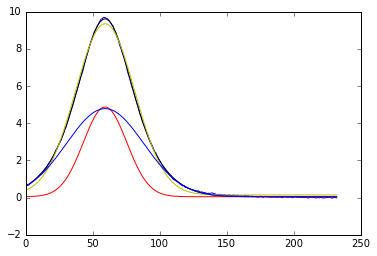

In [156]:
gf = avr_dataD[0][1]
im = sum(gf.image,0)
xx = arange(len(im))
# fit_func = two_gaussian
# popt, pcov = curve_fit(fit_func, xx, im, p0=(100,50, 73,10,40,0))

plot(xx,im)
plot(xx,impr.two_gaussian2(xx,*gf.fit_two_gaussian1D_x),'k')
# perr = np.sqrt(np.diag(pcov))
fit_func = impr.gaussian
popt1, pcov1 = curve_fit(fit_func, xx, im, p0=(100,73,40,0))
plot(xx,fit_func(xx,*popt1),'y')

# print(popt1)
popt = gf.fit_two_gaussian1D_x
print(popt)
plot(xx, impr.gaussian(xx,popt[0]*popt[1],popt[2],popt[3],popt[-1]),'r')
plot(xx, impr.gaussian(xx,popt[0]*(1-popt[1]),popt[2],popt[4],popt[-1]),'b')

(0, 500.0)

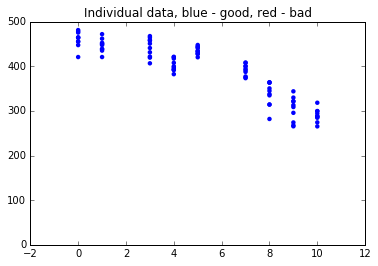

In [147]:
# for each picture
shot_typeN = 1
xs, ys, cs = impr.constract_data_scatter(dataD, shot_typeN, 'fit1D_x',0)
# plt.figure(figsize=(13,4))
scatter(xs,ys,c=cs,linewidths=0)
title("Individual data, blue - good, red - bad")
ylim(bottom=0)

In [148]:
#navrD[0]

In [149]:
#avr_table.T

In [150]:
# Save all data
if folder != '':
    fig1.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'.png'))
    # save pandas table to csv file
    avr_table.to_csv(os.path.join(folder,'avr_table.csv'))
    try:
        with open('all_data.txt', 'rb') as handle:
            res_dict = pickle.loads(handle.read())
    except FileNotFoundError:
        res_dict = {}
    except EOFError:
        res_dict = {}
    res_dict[folder.rstrip(r'\/ ')]={'description':description,'data':navrD}
    with open('all_data.txt', 'wb') as handle:
        pickle.dump(res_dict, handle)
    with open('all_data.json', 'w') as outfile:
        json.dump(res_dict, outfile, cls=impr.JsonCustomEncoder, indent=4)    
    print('Figure and data saved!!!')

#save to mongo db
# get pickle string of avr_table 
ss = 'temp'
avr_table.to_pickle(ss)
with open(ss,'rb') as fl:
    line = fl.read()
os.remove(ss)
# prepear dictionary to load to mongoDB
data_to_db = {
             'date_meas':datetime.datetime.strptime(current_directory[:10],'%Y_%m_%d'),
             'date_mod':datetime.datetime.now(),
             'folder':folder,
             'meas_type':meas_type,
             'labels':[x_lbl, y_lbl],
              'conf_params':conf_params,
              'fits': fits_list,
              'avr_table_pickle':line
             }
# try to find entery with the same 'date_meas' and 'folder' and either update or create entery
res = meas_database.find_one({'date_meas':datetime.datetime.strptime(current_directory[:10],'%Y_%m_%d'),
                 'folder':folder})
if res:
    print('Entery for folder "%s" updated' % folder)
    meas_database.update_one({'_id':res['_id']},{'$set':data_to_db})
else:
    print('Entery for folder "%s" created' % folder)
    meas_database.insert_one(data_to_db)

Figure and data saved!!!
Entery for folder "51 as 44/" updated


In [19]:
# this cell is now for calibration
# as it is not yet tested I do not put it into library what should be done after a while
def get_value(obj, attribute, index):
    """retruns obj.attibute[index] or obj.attribute if index is not defined"""
    if index != None:
        return getattr(obj,attribute)[index]
    else:
        return getattr(obj,attribute)
    
def normalise_individual_image(dictionary_r, signal_shot, calibration_shot, attribute, index=None, do_fit2D = False):
    """normalize each image using attribute[index] value - usually 'total' or 'x_data_fit[0]'
        returns constracted dictionary (like what returns 'load_data()' function"""
    # copy dictionary to normalize it
    dictionary = copy.deepcopy(dictionary_r)
    for folderN, f_dict in dictionary.items():
        # calculate median for calibration images for current folder
        median_calibration = median([get_value(c_elem,attribute,index) for c_elem in f_dict[calibration_shot]])
        for s_elem in f_dict[signal_shot]:
            c_elems = [c_elem for c_elem in f_dict[calibration_shot] if c_elem.shotN == s_elem.shotN]
            if c_elems == []:
                print('s_elem.image_url has no calibration image')
                continue
            coeffitient = get_value(c_elems[0],attribute,index) / median_calibration
            s_elem.image /= coeffitient
            s_elem.total /= coeffitient
            if hasattr(s_elem,'fit1D_x'):
                s_elem.fit1D_x[0] /=coeffitient
                s_elem.fit1D_x[-1] /=coeffitient
            if hasattr(s_elem,'fit1D_y'):
                s_elem.fit1D_y[0] /=coeffitient
                s_elem.fit1D_y[-1] /=coeffitient
            if hasattr(s_elem, 'fit2D'):
                s_elem.fit2D[0] /= coeffitient
                s_elem.fit2D[-1] /= coeffitient
            if hasattr(s_elem,'total_small'):
                s_elem.total_small /= coeffitient
    print('Normalization is complited')
    return dictionary
def normalize_average_image(dictionary_r, signal_shot, calibration_shot, attribute, index=None):
    # copy dictionary to normalize it
    dictionary = copy.deepcopy(dictionary_r)
    # calculate mean for calibration images for all folders
    median_calibration = mean([get_value(item[calibration_shot],attribute,index) for item in dictionary.values()])
    for folder in dictionary:
        try:
            s_elem = dictionary[folder][signal_shot]
            c_elem = dictionary[folder][calibration_shot]
            coeffitient = get_value(c_elem,attribute,index) / median_calibration
            s_elem.image /= coeffitient
            s_elem.total /= coeffitient
            if hasattr(s_elem,'fit1D_x'):
                s_elem.fit1D_x[0] /=coeffitient
                s_elem.fit1D_x[-1] /=coeffitient
            if hasattr(s_elem,'fit1D_y'):
                s_elem.fit1D_y[0] /=coeffitient
                s_elem.fit1D_y[-1] /=coeffitient
            if hasattr(s_elem, 'fit2D'):
                s_elem.fit2D[0] /= coeffitient
                s_elem.fit2D[-1] /= coeffitient
            if hasattr(s_elem,'total_small'):
                s_elem.total_small /= coeffitient
        except:
            # I do not know what exeption may by so for now it catches all of them (nost likely some image is not good)
            print('Something wronge with average data in folder ',folder)
    print('Normalization is complited')
    return dictionary

In [ ]:
from random import shuffle
center = 416.66
delta = 0.005
N=50
scans = np.concatenate(([center-3*N*delta,center-2*N*delta],arange(center-N*delta,center+N*delta,delta),[center+2*N*delta,center+3*N*delta]))
shuffle(scans)
' '.join((str(i) for i in scans))

In [ ]:
from random import shuffle
scans = arange(416.55,416.8,0.01)
# shuffle(scans)
' '.join((str(i) for i in scans))

### Stern-Gerlakh handling

In [ ]:
dat = avr_dataD[4][1]
zz = impr.real_size(arange(dat.image.shape[0]))
yy2 = sum(dat.image,axis=1)
ms = range(-4,5)

In [ ]:
def Stern_Gerlah_fit_numction(zz, z0, distance,width,background, *ampls):
    """Function fitfunc(zz, z0, distance,width,background, *ampls) to fit image in `Stern-Gerlah experiment.
        z0 - position of m_f=0 cloud zz[-1]/2
        distance - displacement between clouds zz[-1]/10
        width - cloud width in gaussian fit  zz[-1]/15
        background 0
        *ampls - unpucked umplitudes of gaussians max(yy2)*width[zz[-1]/15] """
    res = zeros_like(zz)
    res += background
    for i,m in enumerate(ms):
        res += impr.gaussian(zz, ampls[i],z0+m*distance,width,0)
    return res

def Stern_Gerlah_fit_numction_fixed(zz,background, *ampls):
    """Function fitfunc(zz, z0, distance,width,background, *ampls) to fit image in `Stern-Gerlah experiment.
        z0 - position of m_f=0 cloud zz[-1]/2
        distance - displacement between clouds zz[-1]/10
        width - cloud width in gaussian fit  zz[-1]/15
        background 0
        *ampls - unpucked umplitudes of gaussians max(yy2)*width[zz[-1]/15] """
    z0 = 1750
    distance = 320
    width = 700
    res = zeros_like(zz)
    res += background
    for i,m in enumerate(ms):
        res += impr.gaussian(zz, ampls[i],z0+m*distance,width,0)
    return res

In [ ]:
# zz and yy come from above
# yy2 = sum(yy[:,150:250],1)
popt, pcov = curve_fit(Stern_Gerlah_fit_numction_fixed, zz, yy2, p0=(0,*[1e3]*9),bounds=(0,inf))

In [ ]:
plot(zz,Stern_Gerlah_fit_numction_fixed(zz,*popt))
plot(zz,yy2)
background, *ampls = popt
z0 = 1750
distance = 330
width = 680
for i,m in enumerate(ms):
    plot(zz,impr.gaussian(zz, ampls[i],z0+m*distance,width,0),label=m)
legend()

In [ ]:
os.listdir()

In [ ]:
import pandas as pd

In [ ]:
dd = pd.DataFrame.from_csv('Data1.csv')

In [ ]:
dd = dd/dd.max()

In [ ]:
dd.plot()

In [ ]:
ddb = dd.iloc[:-8,:]

In [ ]:
dd.set_index(['B'.dd.B])

In [ ]:
plot(ddb.B,ddb.index)
plot(ddb.B, sq(ddb.B,*popt))

In [ ]:
def sq(x,a,b,c):
    return a - b*sqrt(c-x)

In [ ]:
popt, pcov = curve_fit(sq,ddb.B, ddb.index)

In [ ]:
popt